In [120]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [121]:
#upload the information using BeautifulSoup
url = 'https://en.wikipedia.org/wiki/List_of_best-selling_music_artists'

response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'lxml')

In [122]:
#find the tables located on this page
alltables = soup.find_all('table')
#it finds 5 useful tables

In [123]:
#for each table:
#read the html into a pandas dataframe

m250 = alltables[0]
table1 = pd.read_html(m250.prettify())[0]

m200 = alltables[1]
table2 = pd.read_html(m200.prettify())[0]

m120 = alltables[2]
table3 = pd.read_html(m120.prettify())[0]

m100 = alltables[3]
table4 = pd.read_html(m100.prettify())[0]

m80 = alltables[4]
table5 = pd.read_html(m80.prettify())[0]

In [124]:
#get rid of the first row of data, just titles and such
table1 = table1.drop(0)
table2 = table2.drop(0)
table3 = table3.drop(0)
table4 = table4.drop(0)
table5 = table5.drop(0)

In [125]:
#merge all 5 lists into one dataframe
df = pd.concat([table1, table2, table3, table4, table5])

In [126]:
#rename the headers/column titles, from numbers
df = df.rename(index=str, columns={0: "Artist", 
                                  1: "Country/Market", 
                                  2: "Period Active", 
                                  3: "Year of First Record", 
                                  4: "Genre", 
                                  5: "Total Certified Units", 
                                  6: "Claimed Sales"})

In [127]:
df.head(3)

,Artist,Country/Market,Period Active,Year of First Record,Genre,Total Certified Units,Claimed Sales
1,The Beatles,United Kingdom,1960–1970 [10],1962 [10],Rock / Pop [10],7002271100000000000♠ Total available certifie...,600 million [36] [37] 500 million [38]
2,Elvis Presley,United States,1954–1977 [39],1954 [39],Rock and roll / Pop / Country [39],7002212400000000000♠ Total available certifie...,600 million [48] [49] 500 million [50]
3,Michael Jackson,United States,1964–2009 [51],1971 [51],Pop / Rock / Dance / Soul / R&B [51],7002184600000000000♠ Total available certifie...,350 million [62] [63] 300 million [64] [65]


In [128]:
#renumber indexes, so all tables are included
df = df.reset_index(drop=True)

In [129]:
#set up regular expression to weed out [##] ghost-links
killbrackets = re.compile(r' \[[0-9b]+\]')

#use the regex for each column just in case
df["Artist"] = [killbrackets.sub("", i) for i in df["Artist"]]
df["Country/Market"] = [killbrackets.sub("", i) for i in df["Country/Market"]]
df["Period Active"] = [killbrackets.sub("", i) for i in df["Period Active"]]
df["Year of First Record"] = [killbrackets.sub("", i) for i in df["Year of First Record"]]
df["Genre"] = [killbrackets.sub("", i) for i in df["Genre"]]
df["Total Certified Units"] = [killbrackets.sub("", i) for i in df["Total Certified Units"]]
df["Claimed Sales"] = [killbrackets.sub("", i) for i in df["Claimed Sales"]]

In [130]:
df.head(2)

,Artist,Country/Market,Period Active,Year of First Record,Genre,Total Certified Units,Claimed Sales
0,The Beatles,United Kingdom,1960–1970,1962,Rock / Pop,7002271100000000000♠ Total available certifie...,600 million 500 million
1,Elvis Presley,United States,1954–1977,1954,Rock and roll / Pop / Country,7002212400000000000♠ Total available certifie...,600 million 500 million


In [131]:
#replace "present" to 2018 in Period Active
df["Period Active"] = pd.Series(df["Period Active"]).str.replace("present", "2018")

#calculate the length of years playing music for each band
for i in range(89):
    int1 = int(df["Period Active"][i][5:9])
    int2 = int(df["Period Active"][i][0:4])
    df['Period Active'][i] = int1-int2

#rename column    
df = df.rename(index=str, columns={"Period Active": "Years Active"})

In [132]:
df["Total Certified Units"][0]

'7002271100000000000♠  Total available certified units: 271.1 million  US  : 212.250 million   JPN  : 4.950 million    UK  : 18.045 million    GER  : 8 million    FRA  : 3.890 million     CAN  : 14.455 million    AUS  : 3.060 million     ITA  : 355,000    BRA  : 550,000    SWE  485,000    SPA  : 1.250 million     SWI  : 350,000    BEL  : 265,000     ARG  : 1.606 million     DEN  : 270,000     AUT  : 500,000    POL  : 175,000    NZ  : 660,000   '

In [133]:
#first pickle
df.to_pickle("raw_band_data.pkl")

In [134]:
#we will pull out a lot of information from the "Total Certified Units" Column. 
#Create a new column, called Certified Sales to receive total sales information

df = df.reindex(columns = ['Artist', 
                           'Country/Market', 
                           'Years Active', 
                           'Year of First Record',
                           'Genre',
                           'Total Certified Units',
                           'Claimed Sales',
                           'Certified Sales'])

In [135]:
def totalcertcounts(df):
# takes in the dataframe, just looks at Total Certified Units Column
# Extracts the Total Sales, then uses that information to populate "Certified Sales" Column
    for i in range(89):
        tcurgx = re.compile(r"^[0-9]+[^0-9]+([0-9\.]+)")
        value = (tcurgx.findall(df["Total Certified Units"][i]))
        v1 = value[0]
        v2 = float(v1)
        v3 = v2*1000000
        v4 = int(v3)
        df['Certified Sales'][i] = v4 
    return df

# Use function totalcertcounts to populate "Certified Sales" Column
df = totalcertcounts(df)

In [136]:
# There is a lot more information in that pesky "Total Certified Units" column.
# This whole ordeal will return a dictionary of small dictionaries

bands = {}

def formats(s):
#takes in the raw TCU string
 #  uses the RegularExpressionsStuff to format it
  # returns a list of tuples [(country: number), (country2: number2), ...]'''
    rgxnospaces = re.compile(r"([A-Z]+)\s*(?:: )?([0-9]+\.[0-9]+|[0-9]+,[0-9]{3})") 
    return(rgxnospaces.findall(s))


def makedict(s):
# takes in the post-regex list of tuples
 #  creates a dictionary with 3digit country code is the key, values are numbers
  # returns the dictionary
    monies = {i:aux(j) for i,j in s}
    return monies


def aux(j):
#'''works within makedict(s)
 #  converts millions to actual numbers, and all numbers to ints'''
    if "," in j:
        return int(j.replace(",",""))
    else:
        return int(float(j)*1000000)
    
    
def banddict(df):
#'''takes in the full raw df
 #  returns a dictionary of things we want'''
    for i in range(89):
        ccoded = pd.Series(makedict(formats(df["Total Certified Units"][i])))
        bands[df["Artist"][i]] = ccoded
    return bands 


# Call the function! 
# banddict is a function that calls all the other functions at once.
# gives us a dictionary called "bands". Each band name is the key, and the values are: country code, and albums sold
banddict(df)

{'ABBA': ARG      238000
 AUS     6127000
 AUT      175000
 BEL      380000
 BRA      275000
 CAN     2785000
 DEN      600000
 FIN      656319
 FRA     2750000
 GER    10450000
 JPN     1500000
 MEX      260000
 NZ       297500
 POL      150000
 SPA     1004999
 SWE      800000
 SWI      600000
 UK     18970000
 US     12700000
 dtype: int64, 'AC/DC': ARG      594000
 AUS     7540000
 AUT      380000
 BEL      100000
 CAN     2490000
 DEN      130000
 FIN      321169
 FRA     4179999
 GER    10300000
 ITA      775000
 NZ       140000
 SPA     1355000
 SWE      350000
 SWI      894000
 UK      4400000
 US     79700000
 dtype: int64, 'Adele': AUS     3955000
 BEL      795000
 BRA     1310000
 CAN     6120000
 DEN      747500
 FIN      151639
 GER     4700000
 ITA     1570000
 JPN      100000
 MEX     1490000
 NZ       577500
 POL      300000
 SPA      800000
 SWE      240000
 SWI      510000
 UK     20550000
 dtype: int64, 'Aerosmith': ARG      338000
 AUS      225000
 AUT      125000
 

In [137]:
# need to convert "bands" dictionary to a pandas dataframe
# then combine it with the other columns of data
df2=pd.DataFrame.from_dict(bands, orient='index')
#df2.head(2)

In [138]:
# "bands" has Artists as the index, 
# convert index of df to Artist so they can be combined.
df = df.set_index('Artist') 

In [139]:
#creates df3 as a pandastable of alphabetized artists and their attributes
df3 = pd.concat([df, df2], axis=1)
df3.head(2)

,Country/Market,Years Active,Year of First Record,Genre,Total Certified Units,Claimed Sales,Certified Sales,ARG,AUS,AUT,...,SWE,SWI,UK,US,FIN,GER,MEX,IRE,PHL,NLD
ABBA,Sweden,10,1972,Pop / Disco,7001607000000000000♠ Total available certifie...,200 million 100 million,60700000.0,238000.0,6127000.0,175000.0,...,800000.0,600000.0,18970000.0,12700000.0,656319.0,10450000.0,260000.0,NaN,NaN,NaN
AC/DC,Australia,45,1975,Hard rock / Blues rock / Rock and roll,7002113600000000000♠ Total available certifie...,200 million 150 million,113600000.0,594000.0,7540000.0,380000.0,...,350000.0,894000.0,4400000.0,79700000.0,321169.0,10300000.0,NaN,NaN,NaN,NaN


In [140]:
# We done care about Genre, and Total Certified Units is taken care of now
# drop them away
df3 = df3.drop(columns=['Total Certified Units'])
df3 = df3.drop(columns=["Genre"])

In [141]:
# Renumber the indexes, and make "Artist" its own column again
df4 = df3.reset_index(drop=False)
df4 = df4.rename(index=str, columns={"index": "Artist"})

In [142]:
# "Claimed Sales" is not a useable number, it is a string. Convert it using a function:

def claimedsales(df4):
    for i in range(89):
        claimedrgx = re.compile(r"([0-9\.]+)")
        value = (claimedrgx.findall(df4["Claimed Sales"][i]))
        v1 = value[0]
        v2 = float(v1)
        #print(v1)
        v3 = v2*1000000
        v4 = int(v3)
        df4['Claimed Sales'][i] = v4 
    return df4

df5 = claimedsales(df4)

In [143]:
# 2nd pickle
df5.to_pickle("fixed_band_data.pkl")

In [144]:
# figure out which countries have the most data points
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 88
Data columns (total 29 columns):
Artist                  89 non-null object
Country/Market          89 non-null object
Years Active            89 non-null object
Year of First Record    89 non-null object
Claimed Sales           89 non-null object
Certified Sales         89 non-null float64
ARG                     32 non-null float64
AUS                     73 non-null float64
AUT                     47 non-null float64
BEL                     44 non-null float64
BRA                     49 non-null float64
CAN                     85 non-null float64
DEN                     37 non-null float64
FRA                     73 non-null float64
ITA                     42 non-null float64
JPN                     62 non-null float64
NZ                      51 non-null float64
POL                     34 non-null float64
SPA                     61 non-null float64
SWE                     58 non-null float64
SWI                     56 

In [145]:
# Make dataframe df6 that contains only the 4 countries with most data
df6 = df5.drop(columns=['Artist', 'Country/Market', 'ARG', 'AUT', 'BEL', 'BRA',
       'CAN', 'DEN', 'ITA', 'JPN', 'NZ', 'POL', 'SPA', 'SWE', 'SWI', 'FIN', 'GER', 'MEX', 'IRE', 'PHL', 'NLD'])
df6.head()

,Years Active,Year of First Record,Claimed Sales,Certified Sales,AUS,FRA,UK,US
0,10,1972,200000000,60700000.0,6127000.0,2750000.0,18970000.0,12700000.0
1,45,1975,200000000,113600000.0,7540000.0,4179999.0,4400000.0,79700000.0
2,12,2008,100000000,104900000.0,3955000.0,NaN,20550000.0,NaN
3,48,1973,150000000,84700000.0,225000.0,225000.0,3230000.0,70250000.0
4,20,1998,80000000,64300000.0,NaN,NaN,NaN,NaN


In [146]:
# Delete all NaN values, call it a new dataframe df7
df7 = df6.dropna()

In [147]:
# Some columns have strings instead of numbers... fix that.
df7["Year of First Record"]=df7["Year of First Record"].apply(pd.to_numeric)
df7["Claimed Sales"]=df7["Claimed Sales"].apply(pd.to_numeric)
df7["Years Active"]=df7["Years Active"].apply(pd.to_numeric)

In [148]:
#table of correlations
df7.corr()

,Years Active,Year of First Record,Claimed Sales,Certified Sales,AUS,FRA,UK,US
Years Active,1.000000,-0.597677,-0.181378,-0.384902,-0.456339,0.000744,-0.268204,-0.340634
Year of First Record,-0.597677,1.000000,-0.307751,0.122270,0.463614,-0.061993,0.279158,0.023646
Claimed Sales,-0.181378,-0.307751,1.000000,0.817886,0.225598,0.389270,0.413346,0.803576
Certified Sales,-0.384902,0.122270,0.817886,1.000000,0.537899,0.390070,0.605364,0.944817
AUS,-0.456339,0.463614,0.225598,0.537899,1.000000,0.299414,0.644393,0.362564
FRA,0.000744,-0.061993,0.389270,0.390070,0.299414,1.000000,0.491335,0.153753
UK,-0.268204,0.279158,0.413346,0.605364,0.644393,0.491335,1.000000,0.371046
US,-0.340634,0.023646,0.803576,0.944817,0.362564,0.153753,0.371046,1.000000


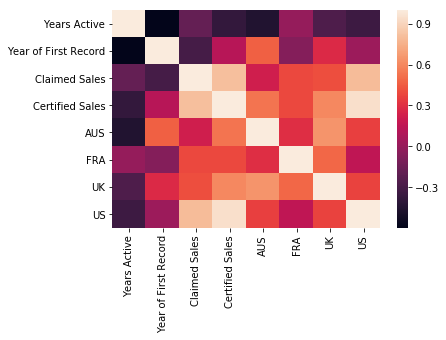

In [149]:
#heatmap to visualize correlations
sns.heatmap(df7.corr());

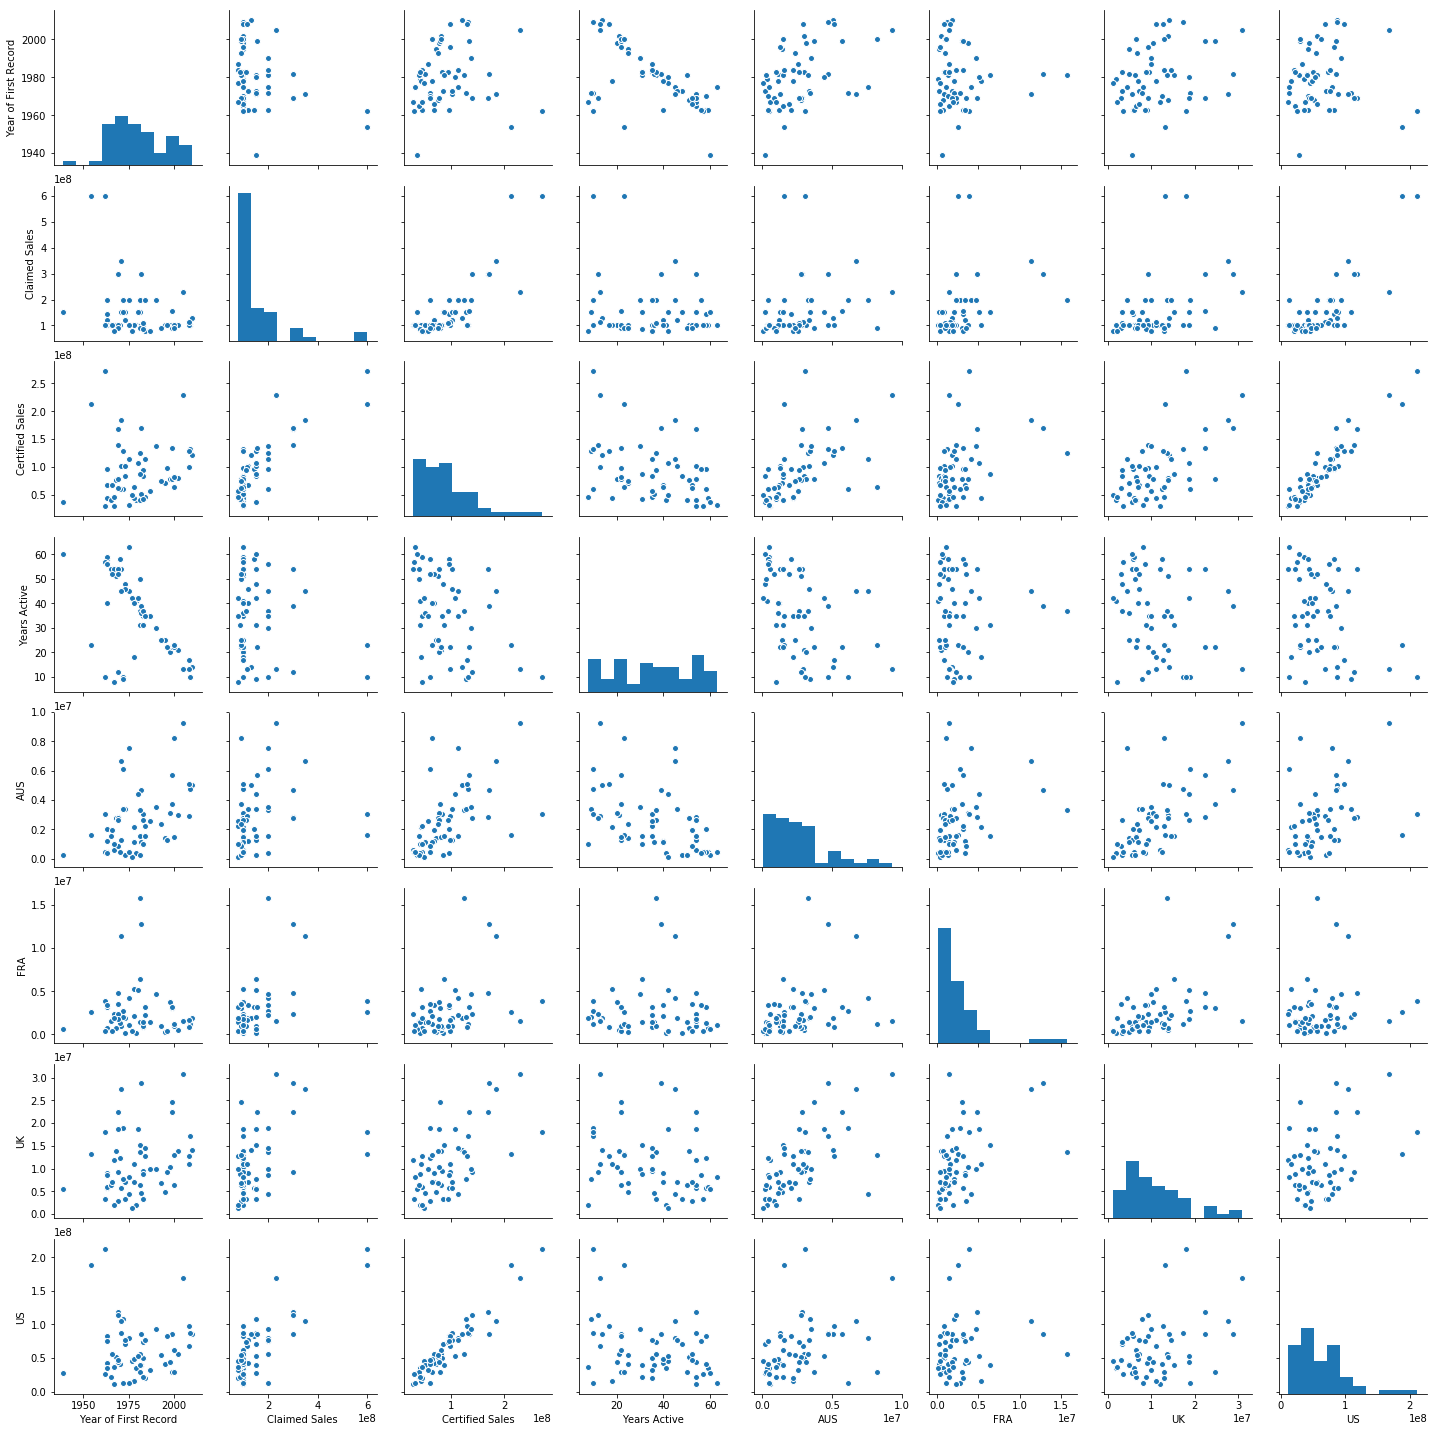

In [150]:
#plot correlations
sns.pairplot(data=df7[["Year of First Record",
                       "Claimed Sales",
                       "Certified Sales",
                       "Years Active",
                       "AUS","FRA","UK","US"]]);

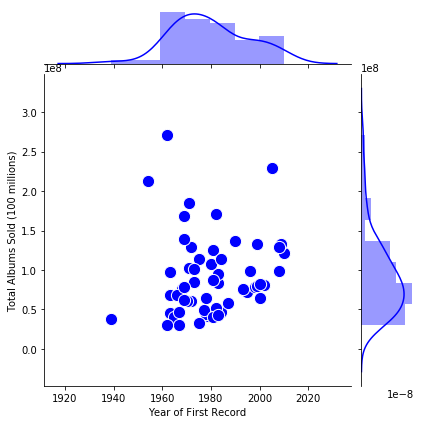

In [151]:
# closer look at Total Albums Sold vs. Year of First Record
d = sns.JointGrid(x="Year of First Record", y="Certified Sales", data=df7)
d = d.plot_joint(plt.scatter, color="b", s=150, edgecolor="white")
d = d.plot_marginals(sns.distplot, kde=True, color="b")
d = d.set_axis_labels(xlabel="Year of First Record",ylabel="Total Albums Sold (100 millions)")

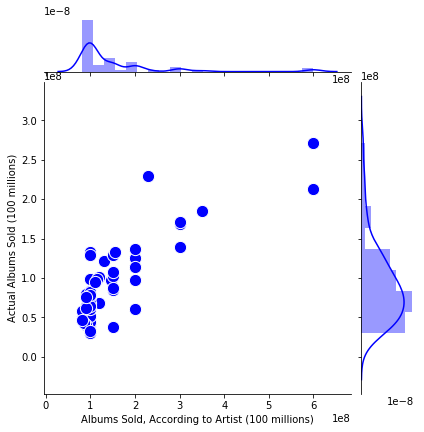

In [152]:
# closer look at Total Albums Sold vs. Claimed Sales
a = sns.JointGrid(x="Claimed Sales", y="Certified Sales", data=df7)
a = a.plot_joint(plt.scatter, color="b", s=150, edgecolor="white")
a = a.plot_marginals(sns.distplot, kde=True, color="b")
a = a.set_axis_labels(xlabel="Albums Sold, According to Artist (100 millions)",ylabel="Actual Albums Sold (100 millions)")

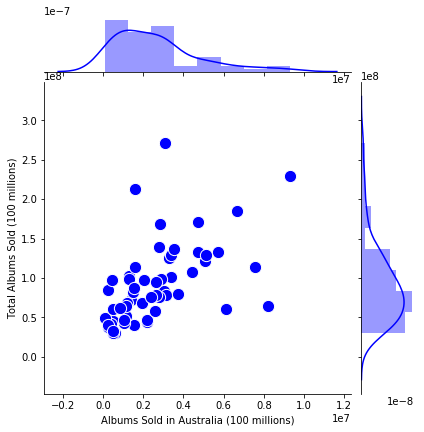

In [153]:
# closer look at Total Albums Sold vs. Albums Sold in Australia
c = sns.JointGrid(x="AUS", y="Certified Sales", data=df7)
c = c.plot_joint(plt.scatter, color="b", s=150, edgecolor="white")
c = c.plot_marginals(sns.distplot, kde=True, color="b")
c = c.set_axis_labels(xlabel="Albums Sold in Australia (100 millions)",ylabel="Total Albums Sold (100 millions)")

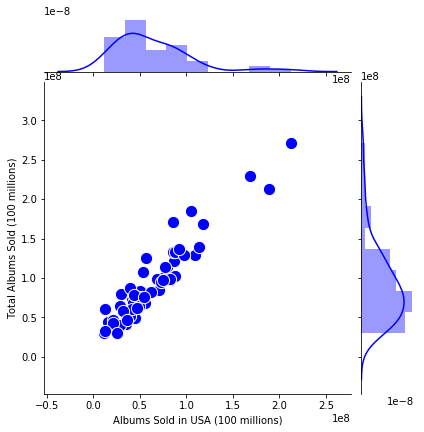

In [154]:
# closer look at Total Albums Sold vs. Albums Sold in USA
b = sns.JointGrid(x="US", y="Certified Sales", data=df7)
b = b.plot_joint(plt.scatter, color="b", s=150, edgecolor="white")
b = b.plot_marginals(sns.distplot, kde=True, color="b")
b = b.set_axis_labels(xlabel="Albums Sold in USA (100 millions)",ylabel="Total Albums Sold (100 millions)")

In [155]:
#rename columns so there are no spaces
df7 = df7.rename(index=str, columns={"Years Active": "Years", 
                               "Claimed Sales": "Claimed", 
                               "Certified Sales": "Sales", 
                               "Year of First Record": "Start"})
df7.head()

,Years,Start,Claimed,Sales,AUS,FRA,UK,US
0,10,1972,200000000,60700000.0,6127000.0,2750000.0,18970000.0,12700000.0
1,45,1975,200000000,113600000.0,7540000.0,4179999.0,4400000.0,79700000.0
3,48,1973,150000000,84700000.0,225000.0,225000.0,3230000.0,70250000.0
6,25,1995,100000000,72000000.0,1400000.0,325000.0,4875000.0,41500000.0
7,58,1963,145000000,97400000.0,2047000.0,3150000.0,5765000.0,82450000.0


In [156]:
# Use patsy to generate a fit
# Stats models
y1, X1 = patsy.dmatrices('Sales ~ AUS + FRA + UK + US', data=df7, return_type="dataframe")

model = sm.OLS(y1, X1)
fit1 = model.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1252.
Date:                Wed, 31 Jan 2018   Prob (F-statistic):           5.48e-51
Time:                        21:44:52   Log-Likelihood:                -961.36
No. Observations:                  57   AIC:                             1933.
Df Residuals:                      52   BIC:                             1943.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.753e+06   1.54e+06      1.139      0.260   -1.34e+06    4.84e+06
AUS            1.9843      0.450      4.412      0.000       1.082       2.887
FRA            2.6738      0.278      9.604      0.000       2.115       3.232
UK             1.2394      0.151      8.218      0.000       0.937       1.542
US             1.0277      0.019     53.861      0.000       0.989       1.066
==============================================================================
Omnibus:                       13.895   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.693
Skew:                           1.027   Prob(JB):                     0.000391
Kurtosis:                       4.546   Cond. No.                     1.65e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
# Use patsy to generate a fit
# Stats models
y2, X2 = patsy.dmatrices('Sales ~ Start + Claimed + AUS + US', data=df7, return_type="dataframe")

model = sm.OLS(y2, X2)
fit2 = model.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     302.6
Date:                Wed, 31 Jan 2018   Prob (F-statistic):           2.51e-35
Time:                        21:44:52   Log-Likelihood:                -1000.9
No. Observations:                  57   AIC:                             2012.
Df Residuals:                      52   BIC:                             2022.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.395e+08   2.56e+08     -2.886      0.006   -1.25e+09   -2.25e+08
Start       3.783e+05    1.3e+05      2.919      0.005    1.18e+05    6.38e+05
Claimed        0.1463      0.028      5.292      0.000       0.091       0.202
AUS            4.5314      0.852      5.321      0.000       2.823       6.240
US             0.7790      0.067     11.647      0.000       0.645       0.913
==============================================================================
Omnibus:                        4.728   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                5.809
Skew:                           0.080   Prob(JB):                       0.0548
Kurtosis:                       4.556   Cond. No.                     3.57e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [158]:
# Use sklearn to fit a linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

lr=LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.5)

lr.fit(X_train, y_train)   #fit on train
lr.score(X2, y2)   #score on test
#lr.get_params(X_test["Intercept"])

0.95482114396813078

In [159]:
# Make predictions using the testing set
y_pred = lr.predict(X_test)

# The coefficients
print('Coefficients: \n', lr.coef_)
print(lr.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred))


Coefficients: 
 [[  0.00000000e+00   3.05902710e+05   9.48488056e-02   4.40853185e+00
    8.65071767e-01]]
[ -5.94555274e+08]
Mean squared error: 170520650351184.91
R2 score: 0.92


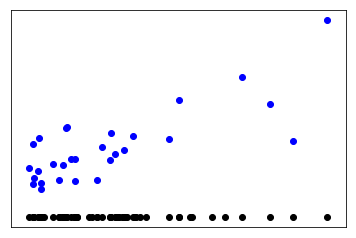

In [160]:
# Plot outputs
plt.scatter(X2["AUS"], y2,  color='black')
plt.scatter(X_test["AUS"], y_pred, color='blue') #linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [161]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

alphabetas=[1e6, 1e7, 1e8, 1e9]
MSE = []

for a in alphabetas:
    encv = ElasticNetCV(cv=10, alphas = [a])
    print("alpha is: "+str(a)+" and R^2 is: "+str(encv.fit(X2,y2).score(X2,y2)))
    print("Mean Squared Error: "+str(mean_squared_error(y2, encv.predict(X2))))
    print("----")
    MSE.append(mean_squared_error(y2, encv.predict(X2)))

alpha is: 1000000.0 and R^2 is: 0.952058050707
Mean Squared Error: 1.21863674062e+14
----
alpha is: 10000000.0 and R^2 is: 0.952055137873
Mean Squared Error: 1.21871078197e+14
----
alpha is: 100000000.0 and R^2 is: 0.952054849785
Mean Squared Error: 1.21871810487e+14
----
alpha is: 1000000000.0 and R^2 is: 0.95205484861
Mean Squared Error: 1.21871813475e+14
----


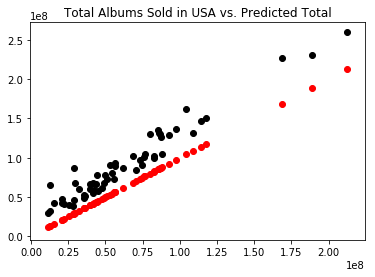

In [162]:
# Plot outputs
y2_pred = lr.predict(X2)
plt.scatter(X2["US"], y2_pred,  color='black')
plt.scatter(X2["US"], X2["US"], color="red")
#plt.scatter(X2["US"],  color='black')
plt.title("Total Albums Sold in USA vs. Predicted Total")

plt.show()

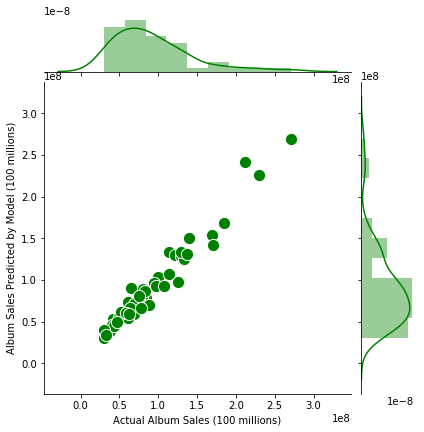

In [163]:
y_predicted = fit2.predict(X2)

g = sns.JointGrid(x=df7["Sales"], y=fit2.predict(X2), data=df7)
g = g.plot_joint(plt.scatter, color="g", s=150, edgecolor="white")
g = g.plot_marginals(sns.distplot, kde=True, color="g")
g = g.set_axis_labels(xlabel="Actual Album Sales (100 millions)",ylabel="Album Sales Predicted by Model (100 millions)")
#g = g.plot(sns.regplot, sns.distplot)

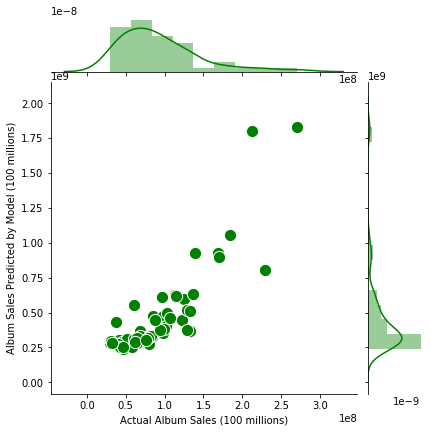

In [164]:
g = sns.JointGrid(x=df7["Sales"], y=fit1.predict(X2), data=df7)
g = g.plot_joint(plt.scatter, color="g", s=150, edgecolor="white")
g = g.plot_marginals(sns.distplot, kde=True, color="g")
g = g.set_axis_labels(xlabel="Actual Album Sales (100 millions)",ylabel="Album Sales Predicted by Model (100 millions)")
#g = g.plot(sns.regplot, sns.distplot)

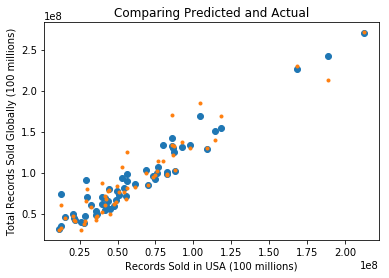

In [165]:
y_test_predicted = (fit2.predict(X_test))

plt.plot(X2["US"], fit2.predict(X2), 'o')
plt.plot(X2["US"], y2, ".")
plt.title('Comparing Predicted and Actual')
plt.xlabel('Records Sold in USA (100 millions)')
plt.ylabel('Total Records Sold Globally (100 millions)');


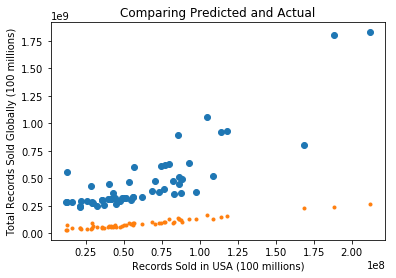

In [166]:
y_test_predicted = (fit1.predict(X_test))

plt.plot(X2["US"], fit1.predict(X2), 'o')
plt.plot(X2["US"], fit2.predict(X2), ".")
plt.title('Comparing Predicted and Actual')
plt.xlabel('Records Sold in USA (100 millions)')
plt.ylabel('Total Records Sold Globally (100 millions)');

ValueError: operands could not be broadcast together with shapes (3249,) (57,) 

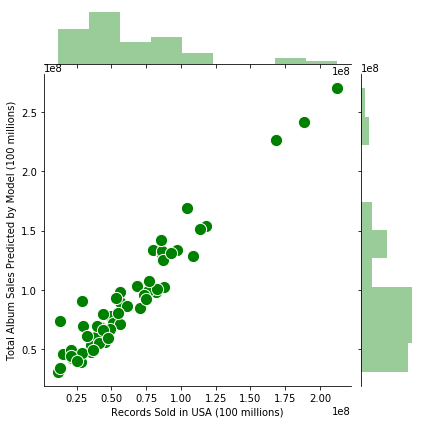

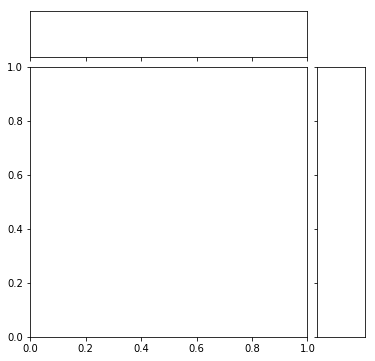

In [167]:
g = sns.JointGrid(x=df7["US"], y=fit2.predict(X2), data=df7)
g = g.plot_joint(plt.scatter, color="g", s=150, edgecolor="white")
g = g.plot_marginals(sns.distplot, kde=False, color="g")
g = g.set_axis_labels(xlabel="Records Sold in USA (100 millions)",ylabel="Total Album Sales Predicted by Model (100 millions)")

a = sns.JointGrid(x=y2, y=fit1.predict(X2), data=df7)
a = a.plot_joint(plt.scatter, color="r", s=150, edgecolor="white")
a = a.plot_marginals(sns.distplot, kde=False, color="r")
a = a.set_axis_labels(xlabel="Records Sold in USA (100 millions)",ylabel="Total Records Sold Globally (100 millions)")
#g = g.plot(sns.regplot, sns.distplot)

In [ ]:
g = sns.JointGrid((df7["Sales"]), y=fit2.predict(X2), data=df7)
g = g.plot_joint(plt.scatter, color="g", s=150, edgecolor="white")
g = g.plot_marginals(sns.distplot, kde=False, color="g")
g = g.set_axis_labels(xlabel="Actual Album Sales (100 millions)",ylabel="Album Sales Predicted by Model (100 millions)")
#g = g.plot(sns.regplot, sns.distplot)

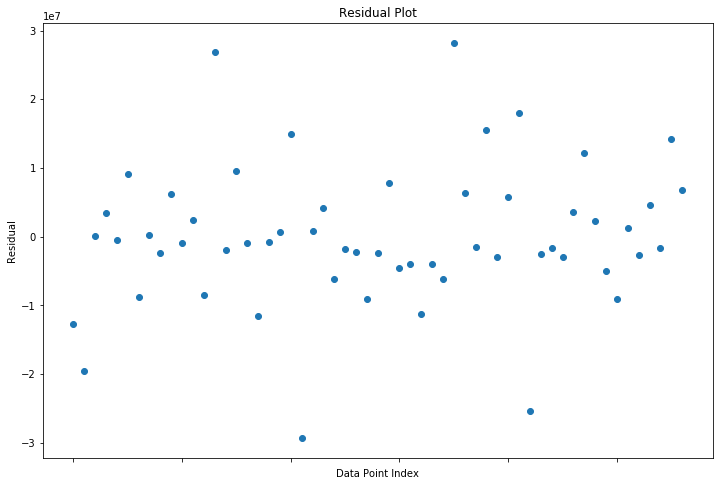

In [169]:
fit2.resid.plot(style='o', figsize=(12,8))
plt.title('Residual Plot')
plt.xlabel('Data Point Index')
plt.ylabel('Residual');

In [ ]:
fit1.resid.plot(style='o', figsize=(12,8));